In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Input, Embedding,TimeDistributed, LSTM, Dropout, Bidirectional, Dense 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset, DataLoader
from allennlp.modules.elmo import Elmo, batch_to_ids
from functools import partial
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

В работе сравниваются результаты NER для одной архитектуры нейронной сети и двух методов создания эмбеддингов (Glove, Elmo).

# NN using Glove embeddings

Для создания Glove эмбеддингов используется glove.840B.300d, длина векторных представлений - 300 символов.

In [4]:
data_train = pd.read_csv('./ner_train.csv')
data_val = pd.read_csv('./ner_val.csv')
data_test = pd.read_csv('./ner_test.csv')

In [5]:
def load_glove_embeddings(filepath, embedding_dim):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            if len(values) != embedding_dim + 1:
                continue
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = embedding
    return embeddings_index

def prepare_data(df):
    sentences = [row.split() for row in df['sentence']]
    tags = [row.split() for row in df['tags']]
    return sentences, tags

def create_vocab_and_embeddings(sentences, glove_embeddings, embedding_dim=300):
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for sentence in sentences:
        for word in sentence:
            if word not in vocab:
                vocab[word] = len(vocab)
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        embedding_matrix[idx] = glove_embeddings.get(word, np.random.normal(scale=0.6, size=(embedding_dim,)))
    return vocab, embedding_matrix

class GloVeNERDataset(Dataset):
    def __init__(self, sentences, tags, vocab, tag_to_idx):
        self.sentences = [[vocab.get(word, vocab['<UNK>']) for word in sentence] for sentence in sentences]
        self.tags = [[tag_to_idx[tag] for tag in tag_list] for tag_list in tags]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.tags[idx]

def collate_fn_glove(batch, tag_to_idx):
    sentences, tags = zip(*batch)
    for i, (sentence, tag_list) in enumerate(zip(sentences, tags)):
        if len(sentence) != len(tag_list):
            return None
    max_len = max(len(sentence) for sentence in sentences)
    padded_sentences = [sentence + [0] * (max_len - len(sentence)) for sentence in sentences]
    padded_tags = [tag_list + [tag_to_idx['PAD']] * (max_len - len(tag_list)) for tag_list in tags]
    tag_masks = [[1] * len(tag_list) + [0] * (max_len - len(tag_list)) for tag_list in tags]
    return (
        torch.tensor(padded_sentences, dtype=torch.long),
        torch.tensor(padded_tags, dtype=torch.long),
        torch.tensor(tag_masks, dtype=torch.bool),
    )

In [6]:
class GloVeNERModel(nn.Module):
    def __init__(self, embedding_matrix, config, tagset_size):
        super(GloVeNERModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.lstm = nn.LSTM(
            input_size=embedding_matrix.shape[1],
            hidden_size=config.N_LSTM_CELLS,
            batch_first=True,
            dropout=config.RECURRENT_DROPOUT,
            bidirectional=False,
        )
        self.fc = nn.Linear(config.N_LSTM_CELLS, tagset_size)
        self.activation = nn.Softmax(dim=-1)

    def forward(self, sentences):
        embeddings = self.embedding(sentences)
        lstm_output, _ = self.lstm(embeddings)
        output = self.fc(lstm_output)
        output = self.activation(output)
        return output
    
def create_tag_mapping(tags):
    unique_tags = set(tag for tag_list in tags for tag in tag_list)
    unique_tags.add('PAD')  # Add PAD token to the unique tags
    tag_to_idx = {tag: idx for idx, tag in enumerate(unique_tags)}
    idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
    return tag_to_idx, idx_to_tag


In [7]:
def train_model(model, dataloader, criterion, optimizer, num_epochs, val_dataloader):
    model.train()
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for i, batch in enumerate(dataloader):
            if batch is None:
                continue
            character_ids, padded_tags, tag_masks = batch
            character_ids = character_ids.cuda()
            padded_tags = padded_tags.cuda()
            tag_masks = tag_masks.cuda()
            
            optimizer.zero_grad()
            outputs = model(character_ids)  # Shape: [batch_size, max_len, tagset_size]
            
            # Reshape for loss calculation
            outputs = outputs.view(-1, tagset_size)  # Shape: [batch_size * max_len, tagset_size]
            targets = padded_tags.view(-1)  # Shape: [batch_size * max_len]
            masks = tag_masks.view(-1).bool()  # Shape: [batch_size * max_len]
            
            # Apply the mask to filter out padding
            outputs = outputs[masks]
            targets = targets[masks]
            
            # print(outputs.size())
            # print(targets)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader)}")
        
        # Validation step
        validate_model(model, val_dataloader, criterion)

def validate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if batch is None:
                continue
            character_ids, padded_tags, tag_masks = batch
            character_ids = character_ids.cuda()
            padded_tags = padded_tags.cuda()
            tag_masks = tag_masks.cuda()
            
            outputs = model(character_ids)
            
            # Reshape for loss calculation
            outputs = outputs.view(-1, tagset_size)
            targets = padded_tags.view(-1)
            masks = tag_masks.view(-1).bool()
            
            outputs = outputs[masks]
            targets = targets[masks]
            
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    print(f"Validation Loss: {val_loss / len(dataloader)}")
    
def test_model(model, dataloader, criterion):
    model.eval()
    test_loss = 0
    total_correct = 0
    total_correct_exc15 = 0
    total_elements = 0

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if batch is None:
                continue
            character_ids, padded_tags, tag_masks = batch
            character_ids = character_ids.cuda()
            padded_tags = padded_tags.cuda()
            tag_masks = tag_masks.cuda()

            outputs = model(character_ids)

            outputs = outputs.view(-1, tagset_size)  # Shape: [batch_size * max_len, tagset_size]
            targets = padded_tags.view(-1)           # Shape: [batch_size * max_len]
            masks = tag_masks.view(-1).bool()        # Shape: [batch_size * max_len]

            outputs = outputs[masks]
            targets = targets[masks]

            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # Get predicted labels
            predictions = torch.argmax(outputs, dim=1)  # Get the index of the max logit (predicted label)

            # Exclude tag 15 for accuracy calculation
            valid_mask = targets != 15
            predictions_exc15 = predictions[valid_mask]
            targets_exc15 = targets[valid_mask]
            
            # Calculate accuracy
            total_correct_exc15 += (predictions_exc15 == targets_exc15).sum().item()
            total_correct += (predictions == targets).sum().item()
            total_elements += targets.size(0)

    accuracy_exc15 = total_correct_exc15 / total_elements if total_elements > 0 else 0
    accuracy = total_correct / total_elements if total_elements > 0 else 0
    print(f"Test Loss: {test_loss / len(dataloader)}")
    print(f"Test Accuracy (excluding tag 15): {accuracy_exc15 * 100:.2f}%")
    print(f"Test Accuracy (total): {accuracy * 100:.2f}%")

In [8]:
train_sentences, train_tags = prepare_data(data_train)
val_sentences, val_tags = prepare_data(data_val)
test_sentences, test_tags = prepare_data(data_test)

In [9]:
glove_filepath = './glove.840B.300d.txt'
embedding_dim = 300
glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim)

In [10]:
sentences = train_sentences + val_sentences + test_sentences
vocab, embedding_matrix = create_vocab_and_embeddings(sentences, glove_embeddings, embedding_dim)

In [11]:
all_tags = train_tags + val_tags + test_tags
tag_to_idx, idx_to_tag = create_tag_mapping(all_tags)
tagset_size = len(tag_to_idx)

In [12]:
if 'PAD' in tag_to_idx:
    tag_to_idx['PAD'] = -1
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items() if idx != -1}

In [12]:
train_dataset = GloVeNERDataset(train_sentences, train_tags, vocab, tag_to_idx)
val_dataset = GloVeNERDataset(val_sentences, val_tags, vocab, tag_to_idx)
test_dataset = GloVeNERDataset(test_sentences, test_tags, vocab, tag_to_idx)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=partial(collate_fn_glove, tag_to_idx=tag_to_idx))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=partial(collate_fn_glove, tag_to_idx=tag_to_idx))
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=partial(collate_fn_glove, tag_to_idx=tag_to_idx))

In [13]:
class Config:
    MAX_LEN = 50
    EMBEDDING_VECTOR_LENGTH = 1024
    N_LSTM_CELLS = 64
    RECURRENT_DROPOUT = 0.1
    LOSS = nn.CrossEntropyLoss()
    OPTIMIZER = 'adam'
    MAX_EPOCHS = 10

config = Config()
tagset_size = len(tag_to_idx)
model = GloVeNERModel(embedding_matrix, config, tagset_size)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.cuda()
train_model(model, train_dataloader, criterion, optimizer, num_epochs=config.MAX_EPOCHS, val_dataloader=val_dataloader)

Epoch 1/10, Loss: 2.1115402330250617
Validation Loss: 2.051425004005432
Epoch 2/10, Loss: 2.0265325519619037
Validation Loss: 2.0230294386545817
Epoch 3/10, Loss: 2.007142096782745
Validation Loss: 2.0114891068140666
Epoch 4/10, Loss: 2.0012206985514993
Validation Loss: 2.0098211431503294
Epoch 5/10, Loss: 1.9982723959094788
Validation Loss: 2.007419691880544
Epoch 6/10, Loss: 1.9943636666744127
Validation Loss: 2.0061675469080607
Epoch 7/10, Loss: 1.9925597667495243
Validation Loss: 2.006038973331451
Epoch 8/10, Loss: 1.991268030298661
Validation Loss: 2.005744727452596
Epoch 9/10, Loss: 1.9903534077126548
Validation Loss: 2.005957535902659
Epoch 10/10, Loss: 1.9894468462198749
Validation Loss: 2.005628924369812


In [14]:
test_model(model, test_dataloader, criterion)

Test Loss: 1.9898181104660033
Test Accuracy (excluding tag 15): 93.26%
Test Accuracy (total): 96.51%


Распределение классов (исключая самый частый нулевой класс 'O')

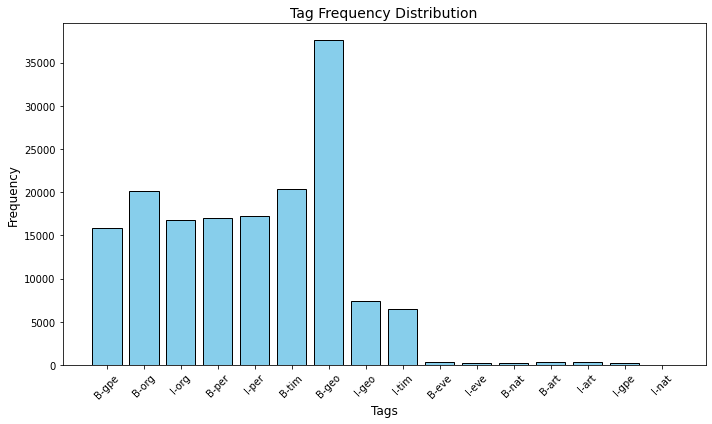

In [19]:
flattened_tags = [tag for sequence in all_tags for tag in sequence if tag != 'O']
tag_counts = Counter(flattened_tags)
tags = list(tag_counts.keys())
counts = list(tag_counts.values())
plt.figure(figsize=(10, 6))
plt.bar(tags, counts, color='skyblue', edgecolor='black')
plt.title('Tag Frequency Distribution', fontsize=14)
plt.xlabel('Tags', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Model Architecture

Embedding -> LSTM -> Linear -> Softmax

Обучение проводилось на 10 эпохах, с использованием CrossEntropyLoss. Полученные результаты: test accuracy (except tag 15) = 0.93 (tag 15 это символ 'O', наиболее частый тэг, обозначающий отсутствие класса у слова). Total test accuracy = 0.97.

# NN Using Elmo Embeddings

Второй подход - использование такой же архитектуры модели, но с другими эмбеддингами - Elmo. Эмбеддинги Glove фиксированы для каждого слова, Elmo эмбеддинги (используя Allennlp библиотеку) задаются в зависимости от контекста. Ожидается, что этот поход кодирования слов даст лучший результат в задаче NER, учитывая контекст.

In [15]:
class NERDataset(Dataset):
    def __init__(self, sentences, tags):
        self.sentences = sentences
        self.tags = tags

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.tags[idx]

def collate_fn(batch, tag_to_idx):
    sentences, tags = zip(*batch)
    for i, (sentence, tag_list) in enumerate(zip(sentences, tags)):
        if len(sentence) != len(tag_list):
            return None
    character_ids = batch_to_ids(sentences)  # Shape: [batch_size, max_len, char_dim]
    max_len = max(len(sentence) for sentence in sentences)
    padded_tags = []
    tag_masks = []
    for tag_list in tags:
        padded_tags.append(tag_list + ['PAD'] * (max_len - len(tag_list)))
        tag_masks.append([1] * len(tag_list) + [0] * (max_len - len(tag_list)))
    padded_tags = torch.tensor([[tag_to_idx.get(tag, -1) for tag in tag_list] for tag_list in padded_tags])
    tag_masks = torch.tensor(tag_masks)
    return character_ids, padded_tags, tag_masks

class SequenceTaggingModel(nn.Module):
    def __init__(self, elmo_options_file, elmo_weight_file, config, tagset_size):
        super(SequenceTaggingModel, self).__init__()
        self.elmo = Elmo(elmo_options_file, elmo_weight_file, num_output_representations=1, dropout=0)
        self.lstm = nn.LSTM(
            input_size=config.EMBEDDING_VECTOR_LENGTH,
            hidden_size=config.N_LSTM_CELLS,
            batch_first=True,
            dropout=config.RECURRENT_DROPOUT,
            bidirectional=False
        )
        self.fc = nn.Linear(config.N_LSTM_CELLS, tagset_size)
        self.activation = nn.Softmax(dim=-1)

    def forward(self, character_ids):
        elmo_output = self.elmo(character_ids)
        elmo_embeddings = elmo_output['elmo_representations'][0]
        lstm_output, _ = self.lstm(elmo_embeddings)
        output = self.fc(lstm_output)
        output = self.activation(output)
        return output


In [16]:
train_dataset = NERDataset(train_sentences, train_tags)
val_dataset = NERDataset(val_sentences, val_tags)
test_dataset = NERDataset(test_sentences, test_tags)

In [17]:
from functools import partial
collate_fn_with_mapping = partial(collate_fn, tag_to_idx=tag_to_idx)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_with_mapping, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_with_mapping, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_with_mapping, drop_last=True)

In [18]:
elmo_options_file = './elmo_options.json'
elmo_weight_file = './elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5'
config = Config()
model = SequenceTaggingModel(elmo_options_file, elmo_weight_file, config, tagset_size)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [19]:
model.cuda()
train_model(model, train_dataloader, criterion, optimizer, num_epochs=config.MAX_EPOCHS, val_dataloader=val_dataloader)

Epoch 1/10, Loss: 2.119515543389997
Validation Loss: 2.1038539969681094
Epoch 2/10, Loss: 2.0471562171022164
Validation Loss: 2.03397772616188
Epoch 3/10, Loss: 2.027056196695178
Validation Loss: 2.0286244658015717
Epoch 4/10, Loss: 2.008199311158494
Validation Loss: 2.0079881288861268
Epoch 5/10, Loss: 2.002235444638884
Validation Loss: 2.007206795999668
Epoch 6/10, Loss: 2.0001234710714058
Validation Loss: 2.006040797137574
Epoch 7/10, Loss: 1.9986134168500693
Validation Loss: 2.0054536633843543
Epoch 8/10, Loss: 1.997613801184003
Validation Loss: 2.005131323065534
Epoch 9/10, Loss: 1.9967067366052351
Validation Loss: 2.0045890704097364
Epoch 10/10, Loss: 1.9959331767785928
Validation Loss: 2.004675412338052


In [20]:
test_model(model, test_dataloader, criterion)

Test Loss: 1.9895344764594263
Test Accuracy (excluding tag 15): 93.10%
Test Accuracy (total): 96.51%


Результаты для второй модели (с Elmo эмбеддингами) практически совпадают с результатами для Glove эмбеддингов. Test Accuracy (excluding tag 15) = 0.93, total test accuracy = 0.97. Отсутствие улучшения результотов в сравнении с контексто-независимыми эмбеддингами Glove может быть объяснено тем, что в текстах, на которых проводится обучение и тестируется модель мало примеров двойного значения слов.

# Conclusion

Для обеих моделей (Glove/Elmo embeddings) получены близкие результаты total accuracy = 0.97. При использовании эмбеддингов Elmo, которые учитывают контекст слова в предложении, не получено значительных улучшений метрики в сравнении с Glove embedding.